In [1]:
!unzip 240.zip

Archive:  240.zip
   creating: 240/
   creating: 240/battery/
  inflating: 240/battery/battery1.jpg  
  inflating: 240/battery/battery10.jpg  
  inflating: 240/battery/battery100.jpg  
  inflating: 240/battery/battery101.jpg  
  inflating: 240/battery/battery102.jpg  
  inflating: 240/battery/battery103.jpg  
  inflating: 240/battery/battery104.jpg  
  inflating: 240/battery/battery105.jpg  
  inflating: 240/battery/battery106.jpg  
  inflating: 240/battery/battery107.jpg  
  inflating: 240/battery/battery108.jpg  
  inflating: 240/battery/battery109.jpg  
  inflating: 240/battery/battery11.jpg  
  inflating: 240/battery/battery110.jpg  
  inflating: 240/battery/battery111.jpg  
  inflating: 240/battery/battery112.jpg  
  inflating: 240/battery/battery113.jpg  
  inflating: 240/battery/battery114.jpg  
  inflating: 240/battery/battery115.jpg  
  inflating: 240/battery/battery116.jpg  
  inflating: 240/battery/battery117.jpg  
  inflating: 240/battery/battery118.jpg  
  inflating: 240/b

In [3]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.2 MB/s eta 0:00:00


In [4]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
import os
import shutil
import random

# Replace this with your actual dataset folder path where class folders are present
dataset_path = '240'

# Path where train and val folders will be created
output_path = './garbage_dataset_split/'
train_ratio = 0.8

class_names = ['battery', 'glass', 'metal', 'organic', 'paper', 'plastic']

# Create output directories
for split in ['train', 'val']:
    for data_type in ['images', 'labels']:
        for class_name in class_names:
            os.makedirs(os.path.join(output_path, split, data_type, class_name), exist_ok=True)

# Split dataset and move files
for class_name in class_names:
    class_folder = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(images)
    split_index = int(len(images) * train_ratio)
    train_images = images[:split_index]
    val_images = images[split_index:]

    for image_name in train_images:
        img_src = os.path.join(class_folder, image_name)
        img_dst = os.path.join(output_path, 'train', 'images', class_name, image_name)
        shutil.copy(img_src, img_dst)

        label_name = os.path.splitext(image_name)[0] + '.txt'
        label_src = os.path.join(class_folder, label_name)
        label_dst = os.path.join(output_path, 'train', 'labels', class_name, label_name)
        if os.path.exists(label_src):
            shutil.copy(label_src, label_dst)

    for image_name in val_images:
        img_src = os.path.join(class_folder, image_name)
        img_dst = os.path.join(output_path, 'val', 'images', class_name, image_name)
        shutil.copy(img_src, img_dst)

        label_name = os.path.splitext(image_name)[0] + '.txt'
        label_src = os.path.join(class_folder, label_name)
        label_dst = os.path.join(output_path, 'val', 'labels', class_name, label_name)
        if os.path.exists(label_src):
            shutil.copy(label_src, label_dst)

print("Dataset split into train and val folders completed.")


Dataset split into train and val folders completed.


In [6]:
dataset_yaml = """
train: ./garbage_dataset_split/train/images
val: ./garbage_dataset_split/val/images

nc: 6
names: ['battery', 'glass', 'metal', 'organic', 'paper', 'plastic']
"""

with open('dataset.yaml', 'w') as f:
    f.write(dataset_yaml)

print("dataset.yaml file created successfully.")


dataset.yaml file created successfully.


In [7]:
import os

# Dataset root path where your class folders are located
dataset_path = '240'  # Change to your actual path

# Output label folders path for train and val (after splitting)
output_base_path = 'garbage_dataset_split'

class_names = ['battery', 'glass', 'metal', 'organic', 'paper', 'plastic']

# Fixed bounding box for centered object covering most of the image (adjust if needed)
# Format: <x_center> <y_center> <width> <height> all normalized (values between 0 and 1)
fixed_bbox = [0.5, 0.5, 0.9, 0.9]  # Assuming object fills 90% of width and height, centered

def create_labels(split):
    for class_id, class_name in enumerate(class_names):
        img_dir = os.path.join(output_base_path, split, 'images', class_name)
        label_dir = os.path.join(output_base_path, split, 'labels', class_name)
        os.makedirs(label_dir, exist_ok=True)

        for img_file in os.listdir(img_dir):
            if img_file.endswith(('.jpg', '.png', '.jpeg')):
                label_file = os.path.splitext(img_file)[0] + '.txt'
                label_path = os.path.join(label_dir, label_file)

                # Write the label file with class and fixed bounding box
                with open(label_path, 'w') as f:
                    bbox_str = ' '.join([str(x) for x in fixed_bbox])
                    f.write(f"{class_id} {bbox_str}\n")

    print(f"YOLO labels created for {split} set.")

# Create labels for train and validation sets
create_labels('train')
create_labels('val')


YOLO labels created for train set.
YOLO labels created for val set.


In [8]:
results = model.train(
    data='dataset.yaml',
    epochs=10,
    imgsz=240,
    batch=16,
    device=0      # set device, 0 for cuda GPU, or 'cpu'
)


Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=240, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tru

In [23]:
import pandas as pd
import os
results_csv = os.path.join("runs", "detect", "train", "results.csv")

# Read CSV
if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    last_row = df.iloc[-1]  # final epoch
    total_loss = last_row["train/box_loss"] + last_row["train/cls_loss"] + last_row["train/dfl_loss"]
    print(f"\nFinal Total Loss: {total_loss}")
    print(f"Box Loss: {last_row['train/box_loss']}, Class Loss: {last_row['train/cls_loss']}, DFL Loss: {last_row['train/dfl_loss']}")
else:
    print("⚠️ results.csv not found. Check your training run path.")


Final Total Loss: 1.42721
Box Loss: 0.14096, Class Loss: 0.39896, DFL Loss: 0.88729


In [9]:
metrics = model.val()

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 372.6±284.1 MB/s, size: 7.5 KB)
val: Scanning /content/garbage_dataset_split/val/labels/battery.cache... 930 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 930/930 1.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 59/59 10.2it/s 5.8s
                   all        930        930      0.885      0.912      0.958      0.958
               battery        155        155      0.961      0.964       0.99       0.99
                 glass        155        155      0.768      0.884      0.927      0.927
                 metal        155        155       0.93      0.858      0.961      0.961
               organic        155        155      0.962      0.974      0.994      0.994
                 paper        1

In [10]:
print("Validation Loss and Metrics:", metrics)

Validation Loss and Metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cdaff57acf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,   

In [11]:
for class_name in ['battery', 'glass', 'metal', 'organic', 'paper', 'plastic']:
    image_folder = f'garbage_dataset_split/val/images/{class_name}'
    results = model.predict(source=image_folder, conf=0.25, verbose=False)


In [12]:
pred_classes = []
for result in results:
    if result.boxes and len(result.boxes) > 0:
        pred_class = int(result.boxes.cls[0].item())  # class of top detection
        pred_classes.append(pred_class)
    else:
        pred_classes.append(-1)  # No detection


In [13]:
true_classes = []
import os

label_folder = f'garbage_dataset_split/val/labels/{class_name}'
image_names = []
for r in results:
    # If r has a 'path' attribute with the image file path:
    if hasattr(r, 'path'):
        image_names.append(os.path.basename(r.path))
    # Otherwise try 'orig_img' or fallback
    elif hasattr(r, 'orig_img'):
        # orig_img is image array, no filename, so fallback:
        # You can maintain your own list of image filenames before predict call
        pass

for img_name in image_names:
    label_file = os.path.splitext(img_name)[0] + '.txt'
    label_path = os.path.join(label_folder, label_file)
    with open(label_path, 'r') as f:
        line = f.readline()
        true_class = int(line.split()[0])
        true_classes.append(true_class)


In [14]:
import glob
import os

image_folder = f'garbage_dataset_split/val/images/{class_name}'
image_paths = glob.glob(os.path.join(image_folder, '*.*'))
image_names = [os.path.basename(p) for p in image_paths]

results = model.predict(source=image_paths, conf=0.25, verbose=False)


In [15]:
results = model.predict(source=image_paths, conf=0.25, verbose=False)

In [16]:
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pred_classes = []
true_classes = []

label_folder = f'garbage_dataset_split/val/labels/{class_name}'

for i, r in enumerate(results):
    # Get predicted classes for image i
    if r.boxes and len(r.boxes) > 0:
        pred_class = int(r.boxes.cls[0].item())  # class of top detection
        pred_classes.append(pred_class)
    else:
        pred_classes.append(-1)  # No detection

    # Load true class from label file
    img_name = os.path.basename(image_paths[i])
    label_file = os.path.splitext(img_name)[0] + '.txt'
    label_path = os.path.join(label_folder, label_file)
    with open(label_path, 'r') as f:
        line = f.readline()
        true_class = int(line.split()[0])
        true_classes.append(true_class)

# Optionally filter out predictions with no detections (-1)
filtered_true = []
filtered_pred = []
for t, p in zip(true_classes, pred_classes):
    if p != -1:
        filtered_true.append(t)
        filtered_pred.append(p)

# Calculate metrics
accuracy = accuracy_score(filtered_true, filtered_pred)
precision = precision_score(filtered_true, filtered_pred, average='macro')
recall = recall_score(filtered_true, filtered_pred, average='macro')
f1 = f1_score(filtered_true, filtered_pred, average='macro')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.7935483870967742
Precision: 0.2
Recall: 0.15870967741935485
F1 Score: 0.17697841726618707


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
print(f"Metrics: {metrics.results_dict}")

Metrics: {'metrics/precision(B)': 0.8845543632248344, 'metrics/recall(B)': 0.9123650377609843, 'metrics/mAP50(B)': 0.9579865434367535, 'metrics/mAP50-95(B)': 0.957980255540953, 'fitness': 0.957980255540953}


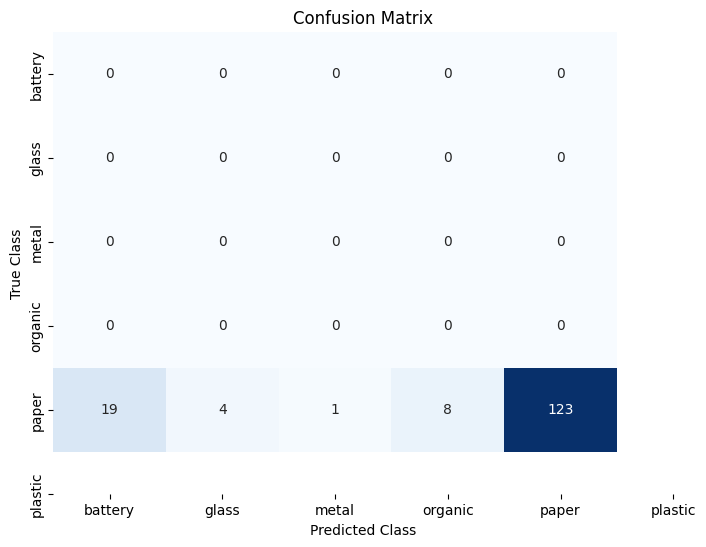

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out no-detection (-1) samples or optionally include them as an extra class
filtered_true = []
filtered_pred = []
for t, p in zip(true_classes, pred_classes):
    if p != -1:
        filtered_true.append(t)
        filtered_pred.append(p)

cm = confusion_matrix(filtered_true, filtered_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()
